# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# 1. Подготовка данных

1.1. Откройте файлы и изучите их.

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import warnings
warnings.filterwarnings("ignore")

In [0]:
d_all = pd.read_csv('/content/drive/My Drive/datasets/gold_recovery_full.csv', index_col='date')

In [0]:
d_train = pd.read_csv('/content/drive/My Drive/datasets/gold_recovery_train.csv', index_col='date')

In [0]:
d_test = pd.read_csv('/content/drive/My Drive/datasets/gold_recovery_test.csv', index_col='date')

In [0]:
d_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22627 non-null  float64
 1   final.output.concentrate_pb                         22629 non-null  float64
 2   final.output.concentrate_sol                        22331 non-null  float64
 3   final.output.concentrate_au                         22630 non-null  float64
 4   final.output.recovery                               20753 non-null  float64
 5   final.output.tail_ag                                22633 non-null  float64
 6   final.output.tail_pb                                22516 non-null  float64
 7   final.output.tail_sol                               22445 non-null  float64
 8   final.output.tail_au                             

In [0]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                               16715 non-null  float64
 8   final.output.tail_au                             

1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

Для того, чтобы рассчитать MAE необходимо избавиться от пропусков.

In [0]:
d_train = d_train.dropna(subset= (['rougher.output.concentrate_au', 'rougher.input.feed_au',
                                   'rougher.output.tail_au', 'rougher.output.recovery']))

In [0]:
C = d_train['rougher.output.concentrate_au']
F = d_train['rougher.input.feed_au']
T = d_train['rougher.output.tail_au']

In [0]:
d_train['rougher.output.recovery_calculate'] = (C*(F-T)) / (F[F!=0]*(C-T)) * 100

Для того, чтобы исключить деление на 0, в знаменателе берем только те значения доли золота в исходном сырье (F), чтобы они не были равны нулю.

In [0]:
d_train['rougher.output.recovery_calculate']

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Name: rougher.output.recovery_calculate, Length: 14287, dtype: float64

In [0]:
d_train['rougher.output.recovery']

date
2016-01-15 00:00:00    87.107763
2016-01-15 01:00:00    86.843261
2016-01-15 02:00:00    86.842308
2016-01-15 03:00:00    87.226430
2016-01-15 04:00:00    86.688794
                         ...    
2018-08-18 06:59:59    89.574376
2018-08-18 07:59:59    87.724007
2018-08-18 08:59:59    88.890579
2018-08-18 09:59:59    89.858126
2018-08-18 10:59:59    89.514960
Name: rougher.output.recovery, Length: 14287, dtype: float64

Рассчитаем МАЕ.

In [0]:
mae = mean_absolute_error(d_train['rougher.output.recovery'], d_train['rougher.output.recovery_calculate'])

In [0]:
mae

9.444891926100695e-15

Средняя абсолютная ошибка, можно сказать, равна 0. Можно сделать вывод, что эффективность обогащения рассчитана правильно

1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [0]:
d_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14287 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14282 non-null  float64
 1   final.output.concentrate_pb                         14282 non-null  float64
 2   final.output.concentrate_sol                        14055 non-null  float64
 3   final.output.concentrate_au                         14283 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14287 non-null  float64
 6   final.output.tail_pb                                14173 non-null  float64
 7   final.output.tail_sol                               14279 non-null  float64
 8   final.output.tail_au                             

In [0]:
d_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5554 non-null   float64
 1   primary_cleaner.input.depressant            5572 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5690 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5840 non-null

Тестовая выборка не содержит данных о final.output, primary_cleaner.output, rougher.output, secondary_cleaner.output, rougher.calculation, т.е. все данные, которые мы получаем на выходе, а также, которые можно посчитать. 

1.4. Проведите предобработку данных.

Поскольку пропуски в целевых данных обусловоены последовательностью технологического процесса, мы не можем знать наперед, какие данные мы получим в итоге, поэтому заполнять пропуски агрегированными данными некорректно. Для обучения модели в данных не должно быть пропусков. Заполним пропуски данными из целого сета, оставшиеся пропуски дропнем. Также, в тестовой выборке отсутствуют целевые признаки, мы можем взять их из целого сета.

In [0]:
d_test = d_test.merge(d_all[['final.output.recovery', 'rougher.output.recovery']], on='date', how='left')

In [0]:
print(d_train['final.output.recovery'].isna().sum())
print(d_train['rougher.output.recovery'].isna().sum())

138
0


In [0]:
d_train = d_train.dropna(subset=['final.output.recovery'])
print(d_train['final.output.recovery'].isna().sum())

0


In [0]:
print(d_test['final.output.recovery'].isna().sum())
print(d_test['rougher.output.recovery'].isna().sum())

442
546


In [0]:
d_test = d_test.dropna(subset=['final.output.recovery'])
d_test = d_test.dropna(subset=['rougher.output.recovery'])
print(d_test['final.output.recovery'].isna().sum())
print(d_test['rougher.output.recovery'].isna().sum())

0
0


Целевые параметры предобработаны.  
Оставшиеся пропуски можно заполнить методом ffill

In [0]:
d_test = d_test.fillna(method='ffill')
d_train = d_train.fillna(method='ffill')

In [0]:
d_test.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

In [0]:
d_train.isna().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
rougher.output.recovery_calculate             0
Length: 87, dtype: int64

Все пропуски заполнены или удалены.  
Проверим данные на наличие дубликатов.

In [0]:
print(d_train.duplicated().sum())
print(d_test.duplicated().sum())

0
0


In [0]:
print(d_train.shape)
print(d_test.shape)

(14149, 87)
(5290, 54)


# 2. Анализ данных

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.  
Исследовательский анализ данных нагляднее проводить на целом сете.

In [0]:
rougher_output_concentrate = d_all[['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb',
                                    'rougher.output.concentrate_au']]

In [0]:
primary_cleaner_output_concentrate = d_all[['primary_cleaner.output.concentrate_ag',
                                            'primary_cleaner.output.concentrate_pb',
                                           'primary_cleaner.output.concentrate_au']]

In [0]:
final_otput_concentrate = d_all[['final.output.concentrate_ag', 'final.output.concentrate_pb',
                                'final.output.concentrate_au']]

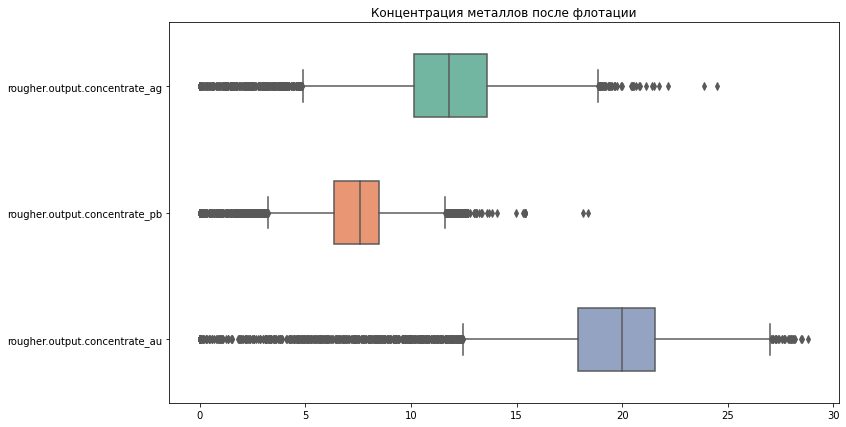

In [0]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=rougher_output_concentrate, orient="h", palette="Set2", width=0.5)\
    .set_title('Концентрация металлов после флотации')

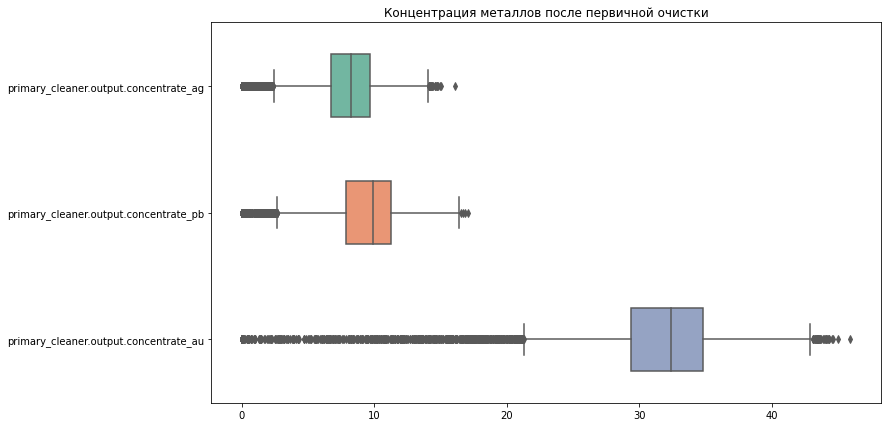

In [0]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=primary_cleaner_output_concentrate, orient="h", palette="Set2", width=0.5)\
    .set_title('Концентрация металлов после первичной очистки')

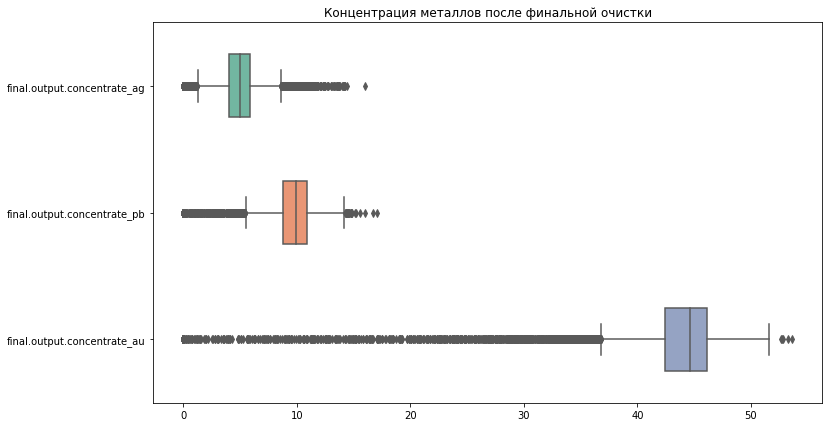

In [0]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data=final_otput_concentrate, orient="h", palette="Set2", width=0.5).\
    set_title('Концентрация металлов после финальной очистки')

Вывод: после процедуры флотации можно отметить невысокую концентрацию серебра и свинца, и высокую концентрацию золота. После первичной очистки концентрация свинца и серебра немного увеличивается, а золота снижается, на финальной стадии все показатели возвращаются к таковым после флотации.  
Таким образом, концентрация золота после каждого этапа очистки увеличивется.

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

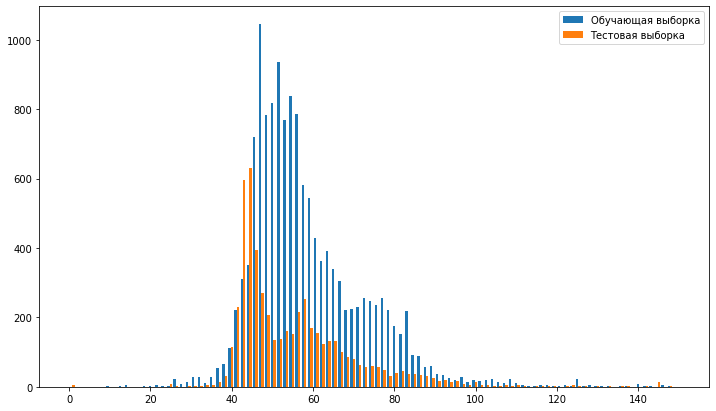

In [0]:
plt.figure(figsize=(12,7))
plt.hist([d_train['rougher.input.feed_size'], d_test['rougher.input.feed_size']], bins = 100,
         label=['Обучающая выборка', 'Тестовая выборка'], range=(0,150))
plt.legend()
plt.show()

Вывод: распределение размеров гранул сырья на обучающей и тестовой выборке немного различается.

<font color='blue'><u><b>КОММЕНТАРИЙ РЕВЬЮЕРА</b></u></font><br />
<font color='green'>
или по-другому: отличаются немного, т.е. можно работать дальше

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [0]:
d_train['rougher.output.concentrate_sum'] = (
    d_train['rougher.output.concentrate_ag']
    + d_train['rougher.output.concentrate_pb']
    + d_train['rougher.output.concentrate_au']
    + d_train['rougher.output.concentrate_sol']
)

In [0]:
d_train['primary_cleaner.output.concentrate_sum'] = (
    d_train['primary_cleaner.output.concentrate_ag']
    + d_train['primary_cleaner.output.concentrate_pb']
    + d_train['primary_cleaner.output.concentrate_au']
    + d_train['primary_cleaner.output.concentrate_sol']
)

In [0]:
d_train['final.output.concentrate_sum'] = (
    d_train['final.output.concentrate_ag']
    + d_train['final.output.concentrate_pb']
    + d_train['final.output.concentrate_au']
    + d_train['final.output.concentrate_sol']
)

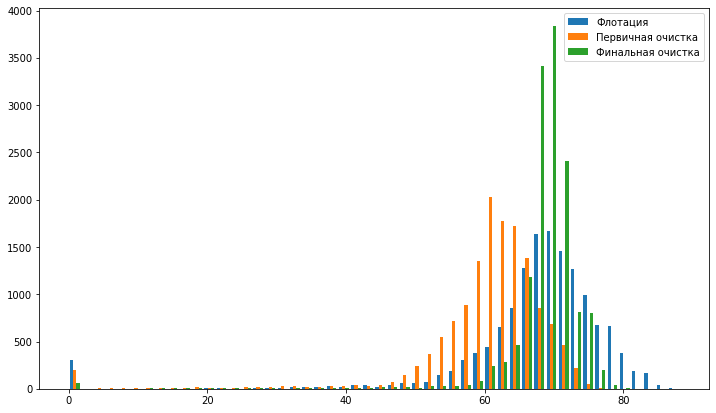

In [0]:
plt.figure(figsize=(12,7))
plt.hist([d_train['rougher.output.concentrate_sum'], 
          d_train['primary_cleaner.output.concentrate_sum'],
          d_train['final.output.concentrate_sum']], bins = 50, 
          label=['Флотация','Первичная очистка', 'Финальная очистка'])
plt.legend()
plt.show()

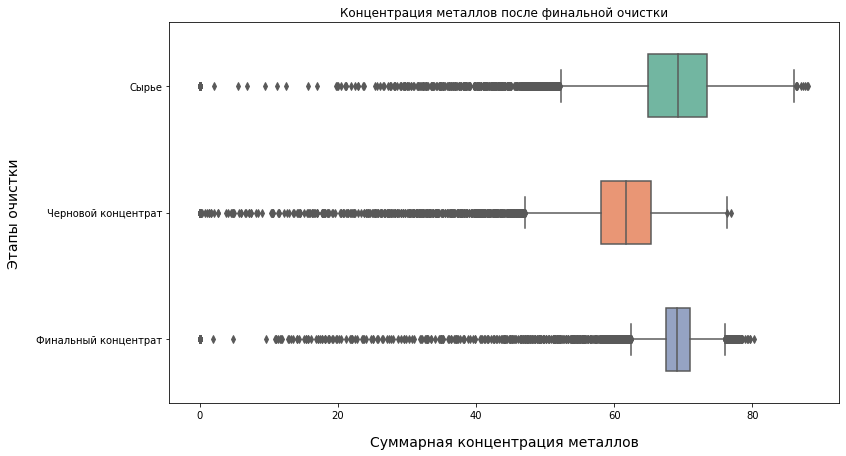

In [0]:
plt.figure(figsize=(12,7))
ax = sns.boxplot(data= d_train[['rougher.output.concentrate_sum',
                                'primary_cleaner.output.concentrate_sum',
                                'final.output.concentrate_sum']],
                  orient="h", palette="Set2", width=0.5)\
    .set_title('Концентрация металлов после финальной очистки')
plt.xlabel('Суммарная концентрация металлов', labelpad=15, fontsize=14)
plt.ylabel('Этапы очистки', labelpad=15, fontsize=14)
plt.yticks(np.arange(3), ('Сырье', 'Черновой концентрат', 'Финальный концентрат'))
plt.show()

Самая высокая суммарная концентрация веществ находится в исходном сырье. На этом графике можно увидеть большое количество выбросов. Для обучения модели их лучше удалить.

In [0]:
d_train = d_train[(d_train['final.output.concentrate_sum'] > 50) &
                  (d_train['rougher.output.concentrate_sum'] > 0.1)  &
                  (d_train['primary_cleaner.output.concentrate_sum'] > 0.1) &
                  (d_train['final.output.concentrate_sum'] > 0.1)]

# 3. Модель

3.1. Напишите функцию для вычисления sMAPE.

In [0]:
def smape(target, prediction):
    smape_rougher = 0
    smape_final = 0
    for i in range(0, len(prediction)):
        smape_rouger_calc = abs(target['rougher.output.recovery'][i] - prediction[i][0]) / \
                            ((abs(target['rougher.output.recovery'][i]) + abs(prediction[i][0])) / 2) * 100
        smape_rougher += smape_rouger_calc
        
        smape_final_calc = abs(target['final.output.recovery'][i] - prediction[i][1]) / \
                           ((abs(target['final.output.recovery'][i]) + abs(prediction[i][1])) / 2) * 100
        smape_final += smape_final_calc
    
    smape_rougher = smape_rougher / len(prediction)
    smape_final = smape_final / len(prediction)
    final_smape_score = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape_score

Целевые признаки для тестовой выборки возьмем из большого сета, дропнем пропуски.

In [0]:
target_train = d_train[['rougher.output.recovery', 'final.output.recovery']]

In [0]:
features_train = d_train[['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']]

In [0]:
target_test = d_test[['rougher.output.recovery', 'final.output.recovery']]

In [0]:
featuers_test = d_test[['primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']]

Выше мы исследовали, что распределение, например, размера гранул руды в обучающей и тестовой выборке разное.
Уравновесим выборки.

In [0]:
#scaler = StandardScaler()

In [0]:
#scaler.fit(features_train)

In [0]:
#features_train_scaled = scaler.transform(features_train)

In [0]:
#features_test_scaled = scaler.transform(featuers_test)

Сделаем smape_final метрикой для кросс-валидации.

In [0]:
score = make_scorer(smape)

Напишем функция для проверки модели путем кросс-валидации:

In [0]:
def cross_val(model, features, target):
    final_score = cross_val_score(model, features, target, cv=5, scoring=score)
    return final_score.mean()

Данные подготовлены, выборки уравновешены, попробуем обучить модель. Начнем с самой простой - линейной регрессии.

In [0]:
reg = LinearRegression()

In [0]:
reg.fit(features_train, target_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
%%time
cross_val(reg, features_train, target_train)

CPU times: user 1.49 s, sys: 499 ms, total: 1.99 s
Wall time: 1.34 s


10.000365242094144

Далее подберем гиперпараметры и обучим дерево и случайный лес.

In [0]:
%%time
for depth in range(4, 10):
    for samples in range(2, 11):
        tree_regressor = DecisionTreeRegressor(random_state=42, max_depth=depth, min_samples_leaf = samples)
        smape_score = cross_val_score(tree_regressor, features_train, target_train, cv=5, scoring=score)
        print('max_depth=', depth, "min_samples_leaf =", samples, " -- ", end='')
        print('smape_score:', smape_score.mean())

max_depth= 4 min_samples_leaf = 2  -- smape_score: 9.408953668678752
max_depth= 4 min_samples_leaf = 3  -- smape_score: 9.637129136313195
max_depth= 4 min_samples_leaf = 4  -- smape_score: 9.460593730710453
max_depth= 4 min_samples_leaf = 5  -- smape_score: 9.26372755357124
max_depth= 4 min_samples_leaf = 6  -- smape_score: 9.260002042504444
max_depth= 4 min_samples_leaf = 7  -- smape_score: 9.260002042504444
max_depth= 4 min_samples_leaf = 8  -- smape_score: 9.260002042504444
max_depth= 4 min_samples_leaf = 9  -- smape_score: 9.270567780487333
max_depth= 4 min_samples_leaf = 10  -- smape_score: 9.276242875601657
max_depth= 5 min_samples_leaf = 2  -- smape_score: 9.87210297004636
max_depth= 5 min_samples_leaf = 3  -- smape_score: 10.045923612016168
max_depth= 5 min_samples_leaf = 4  -- smape_score: 9.92981606369969
max_depth= 5 min_samples_leaf = 5  -- smape_score: 9.529417435799823
max_depth= 5 min_samples_leaf = 6  -- smape_score: 9.442931360871954
max_depth= 5 min_samples_leaf = 7  

Лучший smape для дерева решений на гиперпараметрах:  
max_depth= 4 min_samples_leaf = 6  -- smape_score: 9.260002042504444

In [0]:
%%time
for depth in range(3, 16, 2):
    for estim in range(4, 101, 10):
        forest_regressor = RandomForestRegressor(random_state=42, max_depth=depth, n_estimators=estim)
        smape_score = cross_val_score(forest_regressor, features_train, target_train, cv=5, scoring=score)
        print('max_depth=', depth, ',', "n_estimators =", estim, " -- ", end='')
        print('smape_score:', smape_score.mean())

max_depth= 3 , n_estimators = 4  -- smape_score: 9.048045126103833
max_depth= 3 , n_estimators = 14  -- smape_score: 8.68942516394917
max_depth= 3 , n_estimators = 24  -- smape_score: 8.59142732159778
max_depth= 3 , n_estimators = 34  -- smape_score: 8.61400890075504
max_depth= 3 , n_estimators = 44  -- smape_score: 8.588872360441657
max_depth= 3 , n_estimators = 54  -- smape_score: 8.586863771737741
max_depth= 3 , n_estimators = 64  -- smape_score: 8.6102030720842
max_depth= 3 , n_estimators = 74  -- smape_score: 8.600817481648544
max_depth= 3 , n_estimators = 84  -- smape_score: 8.636598382505639
max_depth= 3 , n_estimators = 94  -- smape_score: 8.634340662457237
max_depth= 5 , n_estimators = 4  -- smape_score: 9.240359881297051
max_depth= 5 , n_estimators = 14  -- smape_score: 9.082454894309926
max_depth= 5 , n_estimators = 24  -- smape_score: 8.891503481254876
max_depth= 5 , n_estimators = 34  -- smape_score: 8.93173106725154
max_depth= 5 , n_estimators = 44  -- smape_score: 8.8559

Лучший smape для случайного леса:  
max_depth= 3 , n_estimators = 54  -- smape_score: 8.586863771737741

Лучше всего себя показывает случайный лес.
Проверим модель на тестовой выборке.

In [0]:
forest_regressor = RandomForestRegressor(random_state=42, max_depth= 3, n_estimators=54)

In [0]:
%%time
forest_regressor.fit(features_train, target_train)

CPU times: user 8.53 s, sys: 1 ms, total: 8.53 s
Wall time: 8.54 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=54, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [0]:
%%time
test_prediction_forest = forest_regressor.predict(featuers_test)
print('sMAPE:', smape(target_test, test_prediction_forest))

sMAPE: 9.27301844448515
CPU times: user 390 ms, sys: 0 ns, total: 390 ms
Wall time: 391 ms


Протестим дерево решений

In [0]:
tree_regressor = DecisionTreeRegressor(random_state=42, max_depth=4, min_samples_leaf = 6)

In [0]:
%%time
tree_regressor.fit(features_train, target_train)

CPU times: user 342 ms, sys: 1 µs, total: 342 ms
Wall time: 344 ms


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=6, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [0]:
%%time
test_prediction_tree = tree_regressor.predict(featuers_test)
print('sMAPE:', smape(target_test, test_prediction_tree))

sMAPE: 12.345463478946273
CPU times: user 396 ms, sys: 0 ns, total: 396 ms
Wall time: 398 ms


**Рассчитаем константный прогноз**

Сделаем DataFrame  с тем же количеством наблюдений, но все значения будут равны среднему по выборке, поскольку целевые значения в тестовой выборке мы как не знаем, эти значения возьмем из обучающей.

In [0]:
target_test_constant = target_test[['rougher.output.recovery','final.output.recovery']]

In [0]:
target_test_constant

,rougher.output.recovery,final.output.recovery
date,,
2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,88.089657,68.910432
2016-09-01 02:59:59,88.412756,68.143213
2016-09-01 03:59:59,87.360133,67.776393
2016-09-01 04:59:59,83.236367,61.467078
...,...,...
2017-12-31 19:59:59,95.172585,68.919891
2017-12-31 20:59:59,94.575036,68.440582
2017-12-31 21:59:59,93.018138,67.092759


In [0]:
target_test_constant["rougher.output.recovery"] = target_train["rougher.output.recovery"].mean()

In [0]:
target_test_constant['final.output.recovery'] = target_train['final.output.recovery'].mean()

In [0]:
target_test_constant

,rougher.output.recovery,final.output.recovery
date,,
2016-09-01 00:59:59,84.620876,66.81803
2016-09-01 01:59:59,84.620876,66.81803
2016-09-01 02:59:59,84.620876,66.81803
2016-09-01 03:59:59,84.620876,66.81803
2016-09-01 04:59:59,84.620876,66.81803
...,...,...
2017-12-31 19:59:59,84.620876,66.81803
2017-12-31 20:59:59,84.620876,66.81803
2017-12-31 21:59:59,84.620876,66.81803


In [0]:
print(target_test.shape)
print(target_test_constant.shape)

(5290, 2)
(5290, 2)


In [0]:
target_test_constant.to_numpy()

array([[84.62087638, 66.81803004],
       [84.62087638, 66.81803004],
       [84.62087638, 66.81803004],
       ...,
       [84.62087638, 66.81803004],
       [84.62087638, 66.81803004],
       [84.62087638, 66.81803004]])

In [0]:
target_test

,rougher.output.recovery,final.output.recovery
date,,
2016-09-01 00:59:59,89.993421,70.273583
2016-09-01 01:59:59,88.089657,68.910432
2016-09-01 02:59:59,88.412756,68.143213
2016-09-01 03:59:59,87.360133,67.776393
2016-09-01 04:59:59,83.236367,61.467078
...,...,...
2017-12-31 19:59:59,95.172585,68.919891
2017-12-31 20:59:59,94.575036,68.440582
2017-12-31 21:59:59,93.018138,67.092759


Подготовили датафрейм и заполнили обе колнки средними значениями.

In [0]:
print('sMAPE:')
print('Случайный лес:', smape(target_test, test_prediction_forest))
print('Константный прогноз:',smape(target_test, target_test_constant.to_numpy()))

sMAPE:
Случайный лес: 9.27301844448515
Константный прогноз: 9.810166998813804


#### Вывод: лучший smape на тестовой выборке показывает модель случайного леса. 
Эта модель показывает результаты лучше, чем у константного прогноза